#### **Import Dataset & Library**
---

In [ ]:
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vijaykumar1799/face-mask-detection")
img_path = os.path.join(path, 'Dataset')

print(img_path)

100%|██████████| 222M/222M [00:11<00:00, 20.5MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/vijaykumar1799/face-mask-detection/versions/1/Dataset


#### **EDA & Prepro**
---

['without_mask', 'mask_weared_incorrect', 'with_mask']



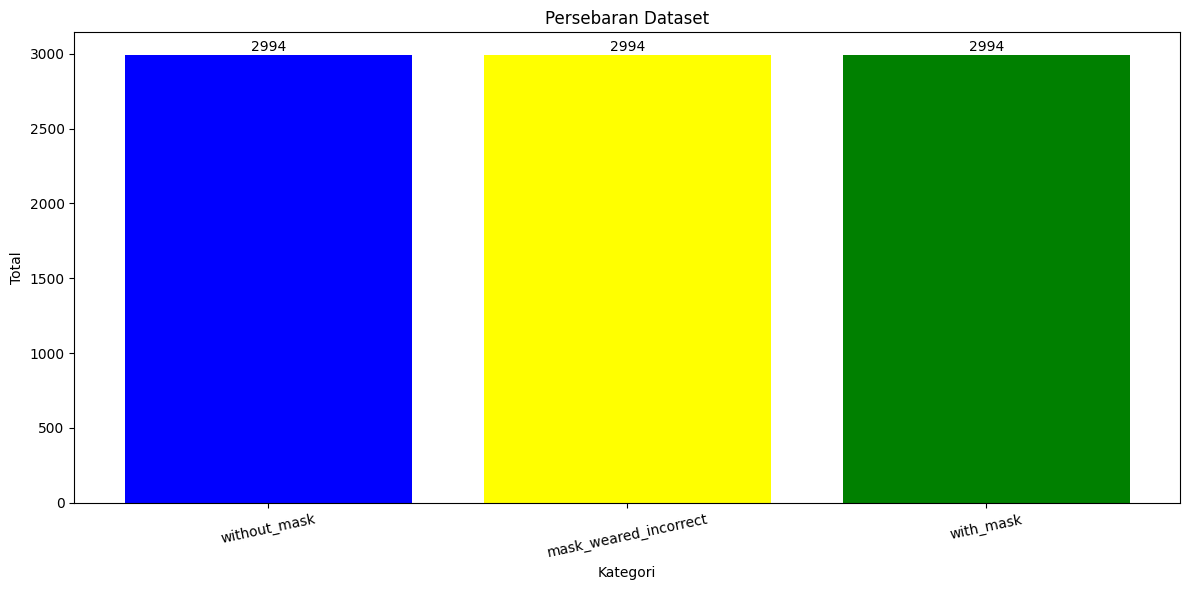

In [ ]:
# ambil setiap class
classes = os.listdir(img_path)
print(f'{classes}\n')

# hitung jumlah gambar disetiap class
counts = []

for i in classes:
  class_path = os.path.join(img_path, i)
  num_images = len(os.listdir(class_path))

  counts.append(num_images)

  # print(f'Class {i}: {num_images}')

# plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, counts, color=['blue', 'yellow', 'green'])

plt.xlabel('Kategori')
plt.ylabel('Total')
plt.xticks(rotation=12)
plt.title('Persebaran Dataset')

# menambahkan angka diatas bar
for bar in bars:
  yval = bar.get_height()

  plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Membagi Data & Augmentasi

# konfigurasi generator
datagen = ImageDataGenerator(
    rescale=1./255,         # normalisasi pixel with min max (0-255 to 0-1)
    rotation_range=20,      # putar gambar sdikit agar model lebih fleksibel
    zoom_range=0.15,        # perbesar gambar
    horizontal_flip=True,   # balik gambar (mirror)
    validation_split=0.2
)

# load data training
train_generator = datagen.flow_from_directory(
    img_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# load data validation
val_generator = datagen.flow_from_directory(
    img_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f'Class Index: {train_generator.class_indices}')

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.
Class Index: {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


#### **Model: MobileNetV2**
---

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, AveragePooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# load base model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# tambahkan lapisan baru (head) diatasnya
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(128, activation='relu')(head_model)
head_model = Dense(128, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(3, activation='softmax')(head_model)

# gabungkan
model = Model(inputs=base_model.input, outputs=head_model)

# freeze lapisan bawah (base model) supaya tidk berubah
for layer in base_model.layers:
  layer.trainable = False

# compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

/tmp/ipython-input-2755035425.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,800,587 (10.68 MB)

 Trainable params: 180,867 (706.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 361,736 (1.38 MB)

In [ ]:
# train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=20
)

# save model
model.save('mask_detection_model.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 150s 583ms/step - accuracy: 0.6332 - loss: 0.7953 - val_accuracy: 0.9030 - val_loss: 0.2834
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 105s 468ms/step - accuracy: 0.8960 - loss: 0.2855 - val_accuracy: 0.9192 - val_loss: 0.2139
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 103s 459ms/step - accuracy: 0.9285 - loss: 0.2132 - val_accuracy: 0.9370 - val_loss: 0.1695
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 104s 464ms/step - accuracy: 0.9436 - loss: 0.1601 - val_accuracy: 0.9443 - val_loss: 0.1569
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 104s 464ms/step - accuracy: 0.9474 - loss: 0.1486 - val_accuracy: 0.9404 - val_loss: 0.1506
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 106s 471ms/step - accuracy: 0.9500 - loss: 0.1411 - val_accuracy: 0.9548 - val_loss: 0.1275
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 103s 459ms/step - accuracy: 0.9628 - loss: 0.1170 - val_accuracy: 0.9599 - val_loss: 0.1165
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 105s 466ms/step - accuracy: 0.9603 -

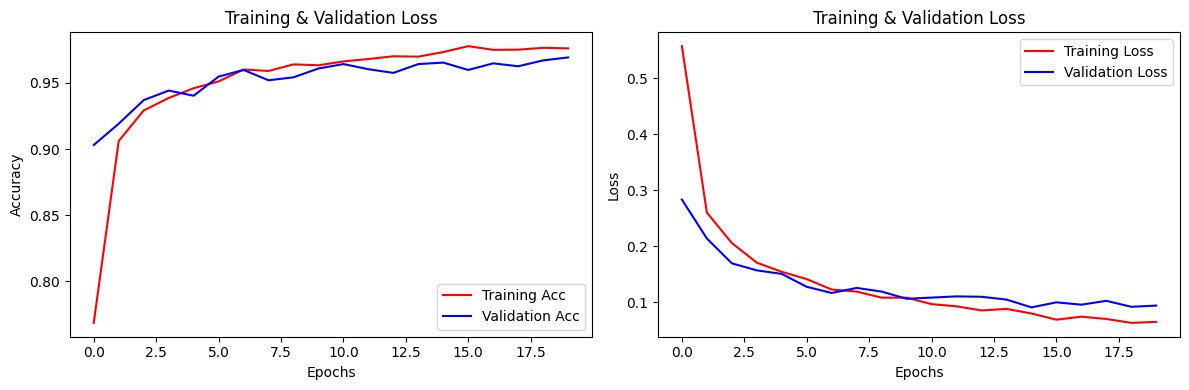

In [ ]:
# Plotting

# ambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# plotting acc
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.title('Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()